# HW 6: Character Classification using CNNs with PyTorch

## Step 1: Data Acquisition + Cleanup

In [17]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import re


def preprocess_dataframe(df):
    # Regular expression pattern to match the pixel columns
    rxcy_pattern = re.compile(r'r\d+c\d+')
    pixel_columns_times = [
        col for col in df.columns if rxcy_pattern.match(col)]

    # Group the dataframe by 'm_label' and count the occurrences
    label_counts = df['m_label'].value_counts()

    # Get the labels that appear at least five times
    valid_labels = label_counts[label_counts >= 5].index.tolist()

    # Select the records with valid labels
    df = df[df['m_label'].isin(valid_labels)]

    # Select the 'm_label' column and the pixel value columns
    df = df[['m_label'] + pixel_columns_times]

    # Get unique characters and create mapping dictionaries
    unique_chars_times = sorted(df['m_label'].unique())
    num_classes_times = len(unique_chars_times)
    char_to_index_times = {char: index for index,
                           char in enumerate(unique_chars_times)}
    index_to_char_times = {index: char for index,
                           char in enumerate(unique_chars_times)}

    # Normalize and reshape the pixel values
    Xs_times = df.drop('m_label', axis=1).to_numpy(dtype=np.float32) / 255.0
    Xs_times = Xs_times.reshape(Xs_times.shape[0], 20, 20)

    # Encode the labels
    Ys_times = np.array([char_to_index_times[char] for char in df['m_label']])

    return Xs_times, Ys_times, char_to_index_times, index_to_char_times, num_classes_times, valid_labels


# Load the dataframe from the CSV file
df_times = pd.read_csv('fonts/TIMES.csv')

# Preprocess the dataframe
Xs_times, Ys_times, char_to_index_times, index_to_char_times, num_classes_times, valid_labels_times = preprocess_dataframe(
    df_times)

# Reshape Xs to match PyTorch's input format
# This indicates that the height and width of the input images are both 20 pixels
Xs_times = np.reshape(Xs_times, (-1, 1, 20, 20))

# Create a TensorDataset from Xs and Ys
dataset_times = TensorDataset(torch.from_numpy(
    Xs_times), torch.from_numpy(Ys_times))

print("num_classes_times:", num_classes_times)

# Split the dataset into training and testing sets
X_train_times, X_test_times, Y_train_times, Y_test_times = train_test_split(
    Xs_times, Ys_times, test_size=0.2, random_state=42)

# Create TensorDatasets for training and testing
train_dataset_times = TensorDataset(
    torch.from_numpy(X_train_times), torch.from_numpy(Y_train_times))
test_dataset_times = TensorDataset(
    torch.from_numpy(X_test_times), torch.from_numpy(Y_test_times))


num_classes_times: 91


In [18]:
print("Training dataset times shape:",
      train_dataset_times[0][0].shape, train_dataset_times[0][1].shape)
print("Testing dataset times shape:",
      test_dataset_times[0][0].shape, test_dataset_times[0][1].shape)

print("Number of samples in the training dataset times:", len(train_dataset_times))
print("Number of samples in the testing dataset times:", len(test_dataset_times))


Training dataset times shape: torch.Size([1, 20, 20]) torch.Size([])
Testing dataset times shape: torch.Size([1, 20, 20]) torch.Size([])
Number of samples in the training dataset times: 1665
Number of samples in the testing dataset times: 417


## Step 2: Build a PyTorch Network

In [19]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        c1Out = 16  
        c2Out = 32  
        self.conv1 = nn.Conv2d(1, c1Out, 3)
        # after pooling: 9 x 9 x c1Out
        self.pool = nn.MaxPool2d(2, 2)  
        self.conv2 = nn.Conv2d(c1Out, c2Out, 3)
        # 3 x 3 x c2Out = 3 x 3 x 32 = 288

        self.pooledOutputSize = c2Out * 3 * 3 
        self.fc1 = nn.Linear(self.pooledOutputSize, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, num_classes)

    def forward(self, x):  
        x = self.pool(F.relu(self.conv1(x)))  
        x = self.pool(F.relu(self.conv2(x))) 
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    #compute the output size after our convolution layers
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = Net(num_classes_times)

In [20]:
def train_model(model, epochs, dataset):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    trainloader = torch.utils.data.DataLoader(
        dataset, batch_size=32, shuffle=True, num_workers=0)

    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            if i % 50 == 49:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 200))
                running_loss = 0.0

    print('Finished Training')


In [21]:
print( "Training... times old model" )
train_model( net, 1000, train_dataset_times )

Training... times old model
[1,    50] loss: 1.122
[2,    50] loss: 1.050
[3,    50] loss: 0.943
[4,    50] loss: 0.904
[5,    50] loss: 0.869
[6,    50] loss: 0.818
[7,    50] loss: 0.748
[8,    50] loss: 0.685
[9,    50] loss: 0.623
[10,    50] loss: 0.574
[11,    50] loss: 0.523
[12,    50] loss: 0.492
[13,    50] loss: 0.458
[14,    50] loss: 0.427
[15,    50] loss: 0.402
[16,    50] loss: 0.371
[17,    50] loss: 0.350
[18,    50] loss: 0.328
[19,    50] loss: 0.308
[20,    50] loss: 0.297
[21,    50] loss: 0.281
[22,    50] loss: 0.267
[23,    50] loss: 0.262
[24,    50] loss: 0.243
[25,    50] loss: 0.234
[26,    50] loss: 0.223
[27,    50] loss: 0.225
[28,    50] loss: 0.202
[29,    50] loss: 0.202
[30,    50] loss: 0.190
[31,    50] loss: 0.199
[32,    50] loss: 0.180
[33,    50] loss: 0.177
[34,    50] loss: 0.171
[35,    50] loss: 0.185
[36,    50] loss: 0.158
[37,    50] loss: 0.153
[38,    50] loss: 0.147
[39,    50] loss: 0.145
[40,    50] loss: 0.142
[41,    50] loss: 0.1

## Step 3: Exploration and Evaluation

### Evaluate the network using cross validation (splitting data into training/testing). What is its accuracy?

In [22]:
def evaluate(model, dataset):
    #load some test data
    testloader = torch.utils.data.DataLoader(dataset, batch_size=32,
                                             shuffle=True, num_workers=0)
    correct = 0
    total = 0

    with torch.no_grad():  # <- Since we are not training, the model does not need to calculate gradients
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Just do a coarse evaluation... how many did we predict correcly?
    print('Accuracy of the network on the test images: %d %%' %
          (100 * correct / total))
    
evaluate(net, test_dataset_times)


Accuracy of the network on the test images: 90 %


### Create and train a different network topology (add more convolution layers, experiment with normalization (batch normalization or dropout), explore other types/sizes of layer). Try to find a topology that works better than the one described above.

In [23]:
class NewNet(nn.Module):
    def __init__(self, num_classes):
        super(NewNet, self).__init__()
        c1Out = 16
        c2Out = 32
        c3Out = 64

        # input size: 20x20x1
        self.conv1 = nn.Conv2d(1, c1Out, 3)
        self.pool = nn.MaxPool2d(2, 2)  
        # output size: 9x9xc1Out

        self.conv2 = nn.Conv2d(c1Out, c2Out, 3)
        #  output size: 7x7xc2Out

        self.conv3 = nn.Conv2d(c2Out, c3Out, 3)
        # output size: 2x2xc3Out = 2x2x64 = 256

        self.pooledOutputSize = c3Out*2*2

        self.fc1 = nn.Linear(self.pooledOutputSize, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

new_net = NewNet(num_classes_times)

In [24]:
print( "Training... times new model" )
train_model( new_net, 1000, train_dataset_times)

Training... times new model
[1,    50] loss: 1.123
[2,    50] loss: 1.004
[3,    50] loss: 0.930
[4,    50] loss: 0.882
[5,    50] loss: 0.806
[6,    50] loss: 0.722
[7,    50] loss: 0.640
[8,    50] loss: 0.570
[9,    50] loss: 0.520
[10,    50] loss: 0.477
[11,    50] loss: 0.441
[12,    50] loss: 0.405
[13,    50] loss: 0.377
[14,    50] loss: 0.352
[15,    50] loss: 0.333
[16,    50] loss: 0.311
[17,    50] loss: 0.294
[18,    50] loss: 0.301
[19,    50] loss: 0.263
[20,    50] loss: 0.246
[21,    50] loss: 0.247
[22,    50] loss: 0.224
[23,    50] loss: 0.216
[24,    50] loss: 0.204
[25,    50] loss: 0.205
[26,    50] loss: 0.196
[27,    50] loss: 0.185
[28,    50] loss: 0.175
[29,    50] loss: 0.170
[30,    50] loss: 0.166
[31,    50] loss: 0.178
[32,    50] loss: 0.153
[33,    50] loss: 0.145
[34,    50] loss: 0.139
[35,    50] loss: 0.138
[36,    50] loss: 0.134
[37,    50] loss: 0.143
[38,    50] loss: 0.126
[39,    50] loss: 0.123
[40,    50] loss: 0.117
[41,    50] loss: 0.1

In [25]:
evaluate(new_net, test_dataset_times)


Accuracy of the network on the test images: 92 %


The newly trained network achieved a remarkable accuracy of 92%, surpassing the performance of the previous model, which achieved an accuracy of 90%. 

### Test the accuracy of your network with character inputs from a DIFFERENT font set. How does it perform?

In [30]:
# Load the dataframe from the CSV file
df_calibri = pd.read_csv('fonts/CALIBRI.csv')

df_calibri = df_calibri[df_calibri['m_label'].isin(valid_labels_times)]

# Preprocess the dataframe
Xs_calibri, Ys_calibri, char_to_index_calibri, index_to_char_calibri, num_classes_calibri, valid_labels_calibri = preprocess_dataframe(df_calibri)


# Reshape Xs to match PyTorch's input format
# This indicates that the height and width of the input images are both 20 pixels
Xs_calibri = np.reshape(Xs_calibri, (-1, 1, 20, 20))

# Create a TensorDataset from Xs and Ys
dataset_calibri = TensorDataset(torch.from_numpy(Xs_calibri), torch.from_numpy(Ys_calibri))

print("num_classes_calibri:", num_classes_calibri)

# Split the dataset into training and testing sets
X_train_calibri, X_test_calibri, Y_train_calibri, Y_test_calibri = train_test_split(Xs_calibri, Ys_calibri, test_size=0.2, random_state=42)


num_classes_calibri: 91


In [31]:
print("Dataset calibri shape:",
      dataset_calibri[0][0].shape, dataset_calibri[0][1].shape)

print("Number of samples in the dataset calibri:", len(dataset_calibri))


Dataset calibri shape: torch.Size([1, 20, 20]) torch.Size([])
Number of samples in the dataset calibri: 728


In [32]:
evaluate(net, dataset_calibri)


Accuracy of the network on the test images: 42 %


In [33]:
evaluate(new_net, dataset_calibri)


Accuracy of the network on the test images: 42 %


To assess my trained network using the Times font dataset generalization capabilities, I further tested the same network on the Calibri font dataset. Both the original model trained on Times font and the newly trained model achieved an accuracy of 42% on the Calibri font dataset.

### Train your best network on inputs from the data from at least 2 different fonts. How does your accuracy compare to the 1-font case? What accuracy do you see when testing with inputs from a font you didn't train on?

#### Train and test on Georgia font dataset

In [44]:
def preprocess_dataframe(df):
    # Regular expression pattern to match the pixel columns
    rxcy_pattern = re.compile(r'r\d+c\d+')
    pixel_columns_times = [
        col for col in df.columns if rxcy_pattern.match(col)]
    
    # Select the 'm_label' column and the pixel value columns
    df = df[['m_label'] + pixel_columns_times]

    # Get unique characters and create mapping dictionaries
    unique_chars_times = sorted(df['m_label'].unique())
    num_classes_times = len(unique_chars_times)
    char_to_index_times = {char: index for index,
                           char in enumerate(unique_chars_times)}
    index_to_char_times = {index: char for index,
                           char in enumerate(unique_chars_times)}

    # Normalize and reshape the pixel values
    Xs_times = df.drop('m_label', axis=1).to_numpy(dtype=np.float32) / 255.0
    Xs_times = Xs_times.reshape(Xs_times.shape[0], 20, 20)

    # Encode the labels
    Ys_times = np.array([char_to_index_times[char] for char in df['m_label']])

    return Xs_times, Ys_times, char_to_index_times, index_to_char_times, num_classes_times


In [40]:
# Load the dataframe from the CSV file
df_georgia = pd.read_csv('fonts/GEORGIA.csv')

df_georgia = df_georgia[df_georgia['m_label'].isin(valid_labels_times)]

# Preprocess the dataframe
Xs_georgia, Ys_georgia, char_to_index_georgia, index_to_char_georgia, num_classes_georgia = preprocess_dataframe(
    df_georgia)

# Reshape Xs to match PyTorch's input format
# This indicates that the height and width of the input images are both 20 pixels
Xs_georgia = np.reshape(Xs_georgia, (-1, 1, 20, 20))

# Create a TensorDataset from Xs and Ys
dataset_georgia = TensorDataset(torch.from_numpy(
    Xs_georgia), torch.from_numpy(Ys_georgia))

print("num_classes_georgia:", num_classes_georgia)

# Split the dataset into training and testing sets
X_train_georgia, X_test_georgia, Y_train_georgia, Y_test_georgia = train_test_split(
    Xs_georgia, Ys_georgia, test_size=0.2, random_state=42)

# Create TensorDatasets for training and testing
train_dataset_georgia = TensorDataset(torch.from_numpy(
    X_train_georgia), torch.from_numpy(Y_train_georgia))
test_dataset_georgia = TensorDataset(torch.from_numpy(
    X_test_georgia), torch.from_numpy(Y_test_georgia))

print("Training dataset georgia shape:",
      train_dataset_georgia[0][0].shape, train_dataset_georgia[0][1].shape)
print("Testing dataset georgia shape:",
      test_dataset_georgia[0][0].shape, test_dataset_georgia[0][1].shape)

print("Number of samples in the training dataset georgia:",
      len(train_dataset_georgia))
print("Number of samples in the testing dataset georgia:",
      len(test_dataset_georgia))


364
num_classes_georgia: 91
Training dataset georgia shape: torch.Size([1, 20, 20]) torch.Size([])
Testing dataset georgia shape: torch.Size([1, 20, 20]) torch.Size([])
Number of samples in the training dataset georgia: 291
Number of samples in the testing dataset georgia: 73


In [46]:
print( "Training... Georgia new model" )

best_network_georgia = NewNet(num_classes_georgia)

train_model( best_network_georgia, 1000, train_dataset_georgia )

Training... Georgia new model
Finished Training


In [42]:
evaluate(best_network_georgia, test_dataset_georgia)


Accuracy of the network on the test images: 46 %


#### Train and test on Arial font dataset

In [49]:
# Load the dataframe from the CSV file
df_arial = pd.read_csv('fonts/ARIAL.csv')

df_arial = df_arial[df_arial['m_label'].isin(valid_labels_times)]

# Preprocess the dataframe
Xs_arial, Ys_arial, char_to_index_arial, index_to_char_arial, num_classes_arial = preprocess_dataframe(
    df_arial)

# Reshape Xs to match PyTorch's input format
# This indicates that the height and width of the input images are both 20 pixels
Xs_arial = np.reshape(Xs_arial, (-1, 1, 20, 20))

# Create a TensorDataset from Xs and Ys
dataset_arial = TensorDataset(torch.from_numpy(
    Xs_arial), torch.from_numpy(Ys_arial))

print("num_classes_arial:", num_classes_arial)

# Split the dataset into training and testing sets
X_train_arial, X_test_arial, Y_train_arial, Y_test_arial = train_test_split(
    Xs_arial, Ys_arial, test_size=0.2, random_state=42)

# Create TensorDatasets for training and testing
train_dataset_arial = TensorDataset(torch.from_numpy(
    X_train_arial), torch.from_numpy(Y_train_arial))
test_dataset_arial = TensorDataset(torch.from_numpy(
    X_test_arial), torch.from_numpy(Y_test_arial))

print("Training dataset arial shape:",
      train_dataset_arial[0][0].shape, train_dataset_arial[0][1].shape)
print("Testing dataset arial shape:",
      test_dataset_arial[0][0].shape, test_dataset_arial[0][1].shape)

print("Number of samples in the training dataset arial:", len(train_dataset_arial))
print("Number of samples in the testing dataset arial:", len(test_dataset_arial))


num_classes_arial: 91
Training dataset arial shape: torch.Size([1, 20, 20]) torch.Size([])
Testing dataset arial shape: torch.Size([1, 20, 20]) torch.Size([])
Number of samples in the training dataset arial: 8348
Number of samples in the testing dataset arial: 2088


In [50]:
print( "Training... Arial new model" )

best_network_arial= NewNet(num_classes_arial)

train_model( best_network_arial, 1000, train_dataset_arial )

Training... Arial new model
[1,    50] loss: 1.127
[1,   100] loss: 1.034
[1,   150] loss: 0.863
[1,   200] loss: 0.805
[1,   250] loss: 0.718
[2,    50] loss: 0.598
[2,   100] loss: 0.514
[2,   150] loss: 0.479
[2,   200] loss: 0.427
[2,   250] loss: 0.410
[3,    50] loss: 0.376
[3,   100] loss: 0.348
[3,   150] loss: 0.323
[3,   200] loss: 0.307
[3,   250] loss: 0.305
[4,    50] loss: 0.289
[4,   100] loss: 0.265
[4,   150] loss: 0.252
[4,   200] loss: 0.224
[4,   250] loss: 0.240
[5,    50] loss: 0.217
[5,   100] loss: 0.220
[5,   150] loss: 0.205
[5,   200] loss: 0.182
[5,   250] loss: 0.197
[6,    50] loss: 0.178
[6,   100] loss: 0.182
[6,   150] loss: 0.174
[6,   200] loss: 0.171
[6,   250] loss: 0.172
[7,    50] loss: 0.163
[7,   100] loss: 0.133
[7,   150] loss: 0.156
[7,   200] loss: 0.163
[7,   250] loss: 0.154
[8,    50] loss: 0.151
[8,   100] loss: 0.134
[8,   150] loss: 0.138
[8,   200] loss: 0.140
[8,   250] loss: 0.128
[9,    50] loss: 0.137
[9,   100] loss: 0.124
[9,   

In [51]:
evaluate(best_network_arial, test_dataset_arial)

Accuracy of the network on the test images: 95 %


### Take a look at some of the characters that have been misclassified. Do you notice any patterns? The network only produces the relative probabilities that the input is any of the possible characters. Can you find examples where the network is unsure of the result?

In [65]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')


def plot_misclassified_examples(model, dataset, index_to_char):
    testloader = torch.utils.data.DataLoader(
        dataset, batch_size=32, shuffle=True, num_workers=0)
    misclassified_examples = []

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            for i in range(len(labels)):
                if predicted[i] != labels[i]:
                    true_label = labels[i].item()
                    predicted_label = predicted[i].item()
                    # Check if the misclassification already exists in the list
                    if (true_label, predicted_label) not in [(example[1], example[2]) for example in misclassified_examples]:
                        misclassified_examples.append(
                            (images[i], true_label, predicted_label))

    # Plot misclassified examples
    num_examples = len(misclassified_examples)
    num_rows = int(num_examples / 4) + (0 if num_examples % 4 == 0 else 1)
    fig, axes = plt.subplots(num_rows, 4, figsize=(12, 3*num_rows))

    for i, (image, true_label, predicted_label) in enumerate(misclassified_examples):
        ax = axes[i // 4, i % 4]
        ax.imshow(image.squeeze(), cmap='gray')
        true_char = chr(index_to_char[true_label])
        predicted_char = chr(index_to_char[predicted_label])
        ax.set_title(f'True: {true_char}, Predicted: {predicted_char}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()


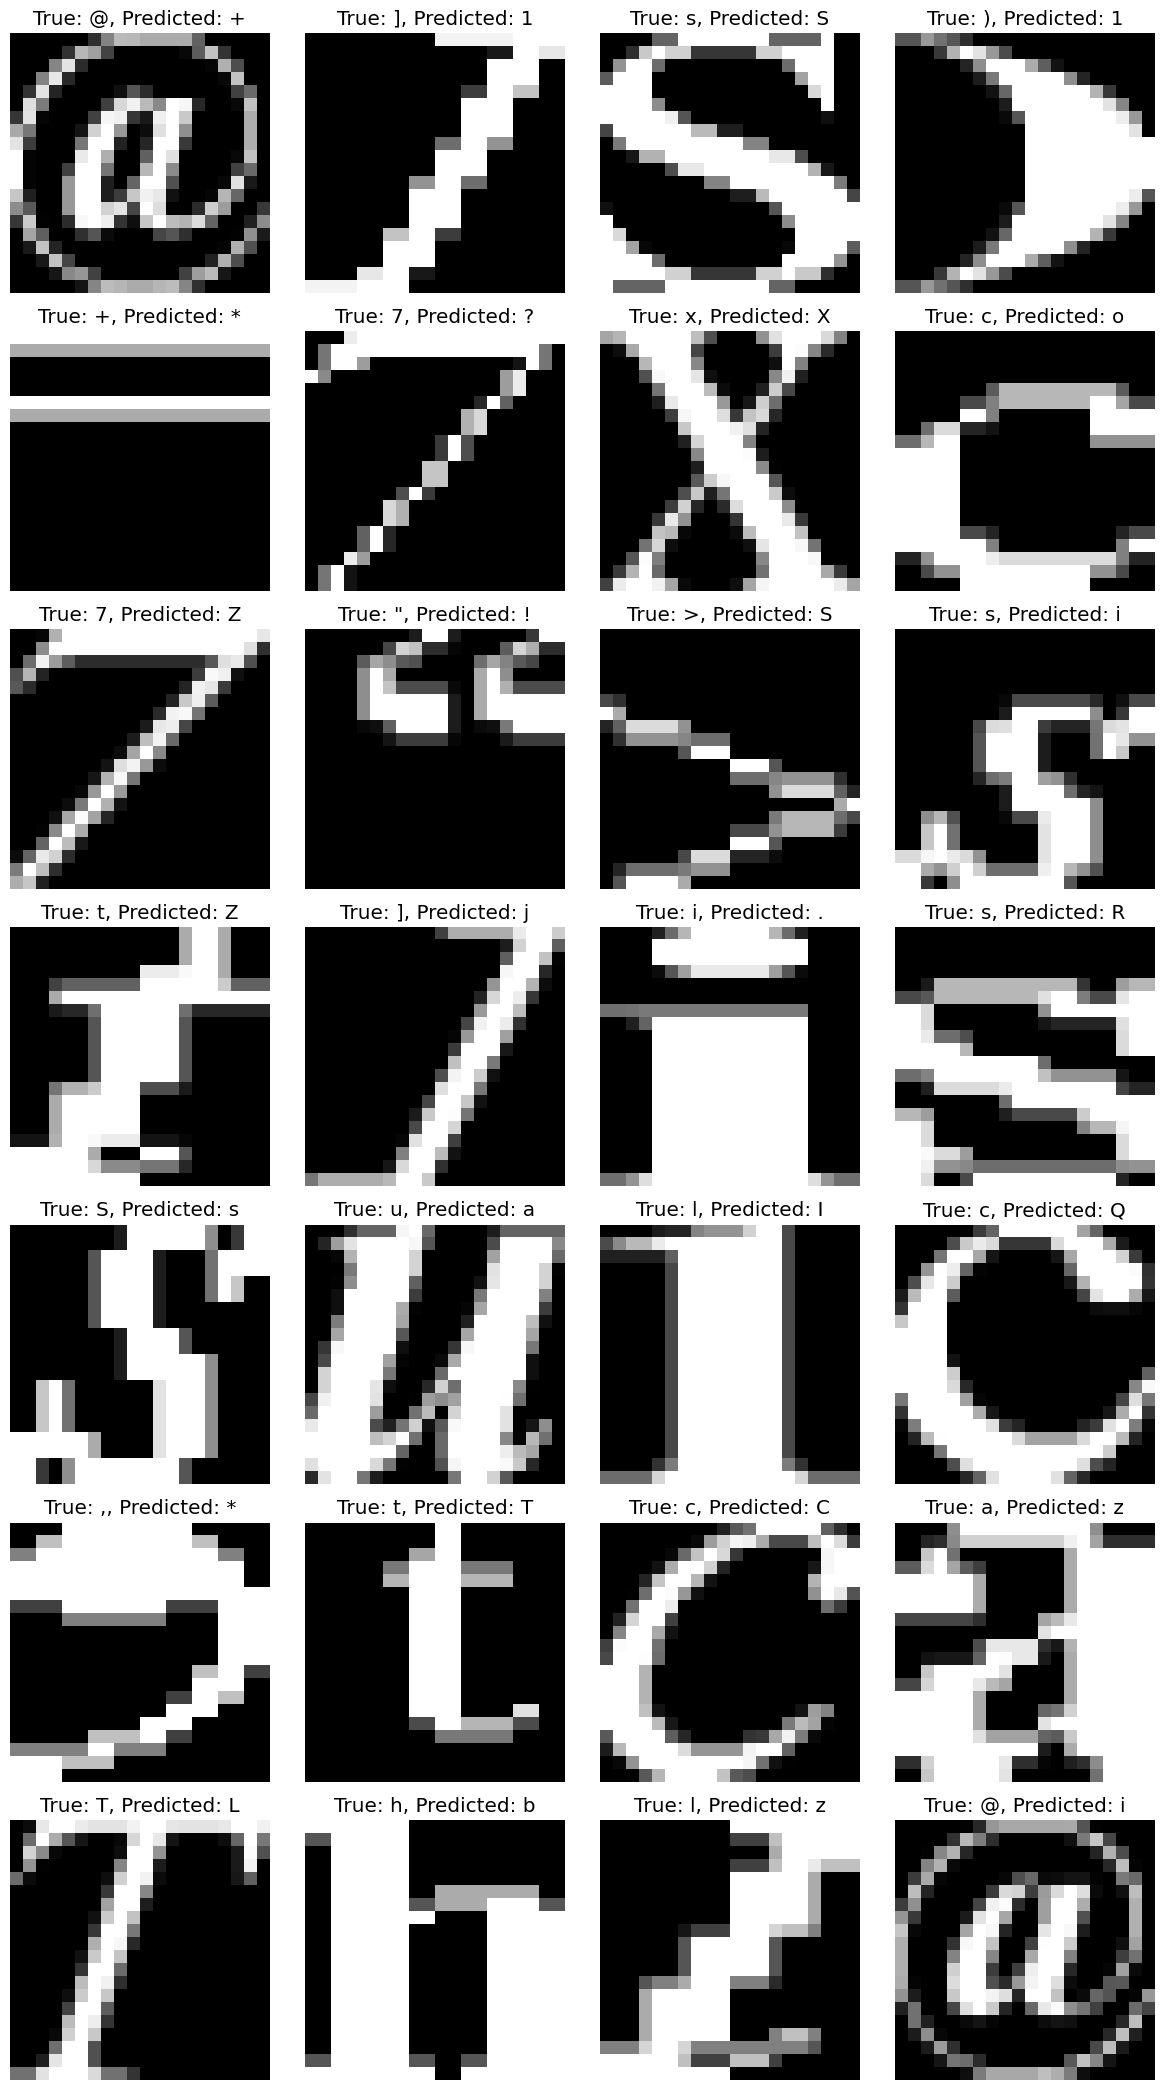

In [66]:
plot_misclassified_examples(
    new_net, test_dataset_times, index_to_char_times)


Upon examining the misclassified characters, I found that many of the misclassifications involve characters that have similar visual representations or share common features. For instance, there are instances where lowercase 'c' is misclassified as uppercase 'C', or the right square bracket ']' is misclassified as the letter 'j'. Additionally, there are occurrences where 'c' is misclassified as 'o'. These observations suggest that the network encounters difficulty distinguishing between characters that possess visual similarities or share common visual elements.

In addition to the visual similarities, it is worth noting that some instances where the images themselves are not very clear. This can pose challenges for the network in accurately recognizing certain characters, such as the '+' or ']'. In such cases, the network's performance can be affected by the quality and accuracy of the training data.

By being aware of these factors, we can reason that refining the training data, resolving labeling inconsistencies, and obtaining clearer images probably can help improve the network's ability to correctly classify these challenging characters.